<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/interp/pydata-hh-surrogate-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining Deep Neural Networks using Surrogate Models

https://www.meetup.com/en-AU/PyData-Hamburg/events/269007662/

_Deep Neural Networks generalize well from training data, however, they typically are black boxes and how they come to a conclusion is not comprehensible. Decision Trees can be much more comprehensible but unlike Neural Networks they tend to overfit when trained on real world data and are hard to regularize. But what if we train decision trees on data generated by a neural network tuned for generalization? Our hope is that the high capacity of the deep neural network will be able to do a really good job learning the structures underlying the training data and then be able to be a good teacher to our decision tree. As it turns out, this approach gives us a dial to be tuned between predictive power and explainability that goes all the way from hand crafted rules to deep neural networks._

_Oliver Zeigermann, oliver.zeigermann@gmail.com, https://twitter.com/DJCordhose, https://www.linkedin.com/in/oliver-zeigermann-34989773/_

## More on surrogate models
* https://en.wikipedia.org/wiki/Surrogate_model
* https://christophm.github.io/interpretable-ml-book/global.html

## And on model interpretation in general
* https://christophm.github.io/interpretable-ml-book/simple.html
* https://compstat-lmu.github.io/iml_methods_limitations/

# Annotated Poster from http://scaledml.org/2020/  
![Poster Scaled ML 2020](https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/poster-scaled-ml-2020.jpg?raw=1)

# Transpareancy as an ethical concern

![Transparency is ethical](https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/salesforce-transparency-ethics.jpg?raw=1)

Richard Socher (https://www.socher.org/) at http://scaledml.org/2020/

# Steps Taken

1. Train Neural Network using the data you have and make it generalize well
2. Generate a larger and evenly distributed set of training data by feeding a grid of data through the neural network
3. Use this new training data to train a unregularized decision tree
    1. Decision tree will still overfit, but on data that is already very general (because of step 2)
    1. Scores will show the tree can fit perfectly on generated data
4. Use typical regularization for decision tree not to make it generalize better, but to have a dial between explainability and accuracy
  1. depth
  2. number of leaf nodes
  3. etc.
5. Use tree for explain plan and code generation
  1. multiple checks can be combined to one
  2. different style of code can be generated
6. Feature Importance and Bias

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']

cmap = ListedColormap(colors)

In [2]:
!nvidia-smi

Fri Feb 28 19:40:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [4]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
random_seed = 42

In [0]:
tf.random.set_seed(random_seed)

In [0]:
import numpy as np

np.random.seed(random_seed)

In [8]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

     |████████████████████████████████| 71kB 3.0MB/s 


In [0]:
from lrcurve import KerasLearningCurve

In [0]:
import pandas as pd
import numpy as np

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html

from matplotlib.ticker import FuncFormatter

import numpy as np

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 110
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)

def plot_samples(samples, ax, legend):
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
    ax.add_artist(class_legend)
    
    return ax, scatter

def plot_samples_markers(samples, ax, legend):
  y = samples[2]
  bad = samples[y == 0]
  good = samples[y == 1]
  fair = samples[y == 2]

  labels = ["High Risk", "Low Risk", "Medium Risk"]
  classes = [bad, good, fair]
  markers = ['v', 'd', '^']

  for label, clazz, color, marker in zip(labels, classes, colors, markers):
      ax.scatter(
          clazz[0], 
          clazz[1],
          label=label,
          color=color,
          marker=marker,
          s=100,
          edgecolors='k',
          alpha=0.8)
  if legend:
    ax.legend()
  return ax, None
      

def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   n_samples=None, proba=True, prediction=True, legend=True, 
                   scatter=True,
                   ax=None
                  ):
    if x_data is not None:
      assert x_data.shape == y_data.shape, "x and y must have the same dimension"
    if x_data  is not None and ground_truth is not None:
      assert x_data.shape == ground_truth.shape, "input and ground truth need the same number of samples"
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots()

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    
    if scatter:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
      if n_samples:
        samples = samples.sample(n_samples, random_state=42)
      plot_samples_markers(samples, ax, legend)
    return ax 


In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')
# local
# df = pd.read_csv('../../data/insurance-customers-1500.csv', sep=';')

In [13]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [0]:
# groups: "High Risk", "Low Risk", "Medium Risk"
  
y = df['group'].values
X = df.drop('group', axis='columns').values

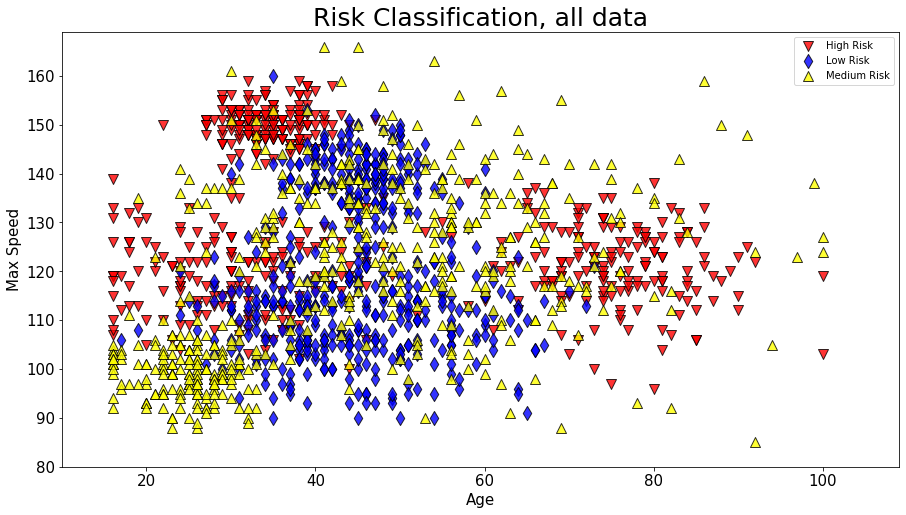

In [15]:
plotPrediction(clf=None, x_data=X[:, 1], y_data=X[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y,
                title="Risk Classification, all data");

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_seed, stratify=y)

# We just use the first two variables

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]
X_2_dim = X[:, :2]

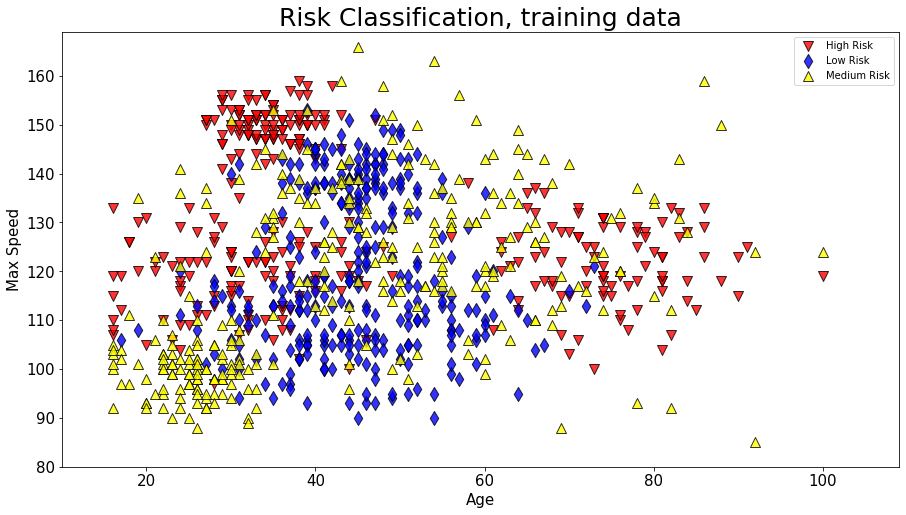

In [19]:
plotPrediction(clf=None, x_data=X_train[:, 1], y_data=X_train[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_train,
                title="Risk Classification, training data");

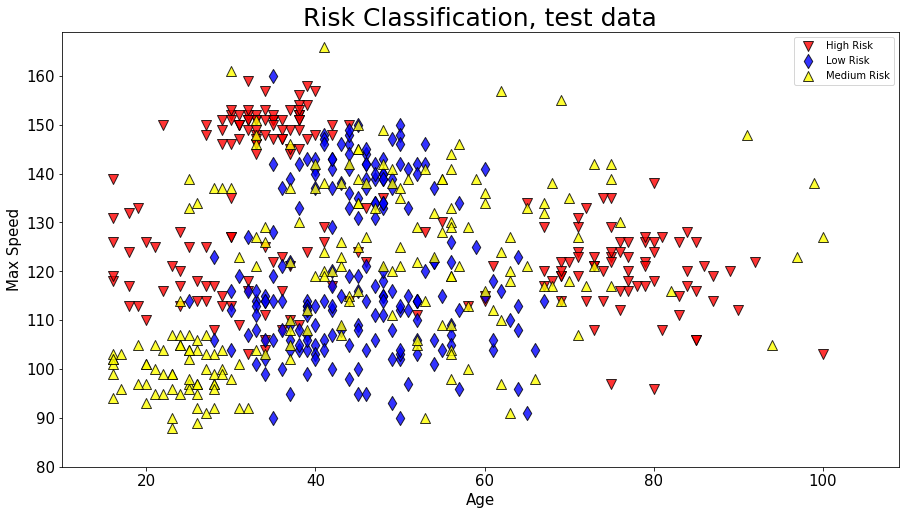

In [20]:
plotPrediction(clf=None, x_data=X_test[:, 1], y_data=X_test[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_test,
               title="Risk Classification, test data");

# Step 1: Train Neural Network using the data you have and make it generalize well


There are many ways of regualizing, and all work reasonably well on a problem like this, more on regualirization: https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-basics-regularization.ipynb

Self-Normalizing Neural Networks (https://arxiv.org/abs/1706.02515)
* https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/AlphaDropout  

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, AlphaDropout

num_features = 2
num_categories = 3

dropout = 0.3
selu_dropout_model = tf.keras.Sequential()

selu_dropout_model.add(Input(name='input', shape=(num_features,)))

selu_dropout_model.add(Dense(name='hidden1', units=500, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='hidden2', units=250, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='output', units=num_categories, activation='softmax'))

selu_dropout_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

model = selu_dropout_model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 250)               125250    
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 250)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 753       
Total params: 127,503
Trainable params: 127,503
Non-trainable params: 0
_________________________________________________________________


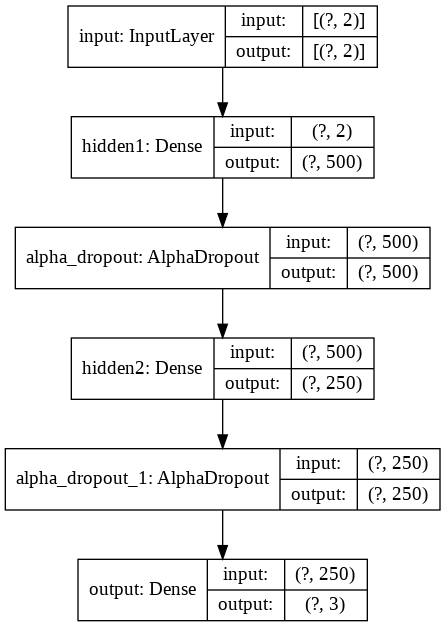

In [22]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=dpi)

In [23]:
%%time 

# BATCH_SIZE = 10
BATCH_SIZE = 500
EPOCHS = 3000

PATIENCE = 500
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE)

history = model.fit(x = X_train_2_dim,
                    y = y_train,
                    validation_data=(X_test_2_dim, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 46.7 s, sys: 3.95 s, total: 50.7 s
Wall time: 47.1 s


In [24]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.896609452035692, 0.6933333)

In [25]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.8513637483119965, 0.6933333)

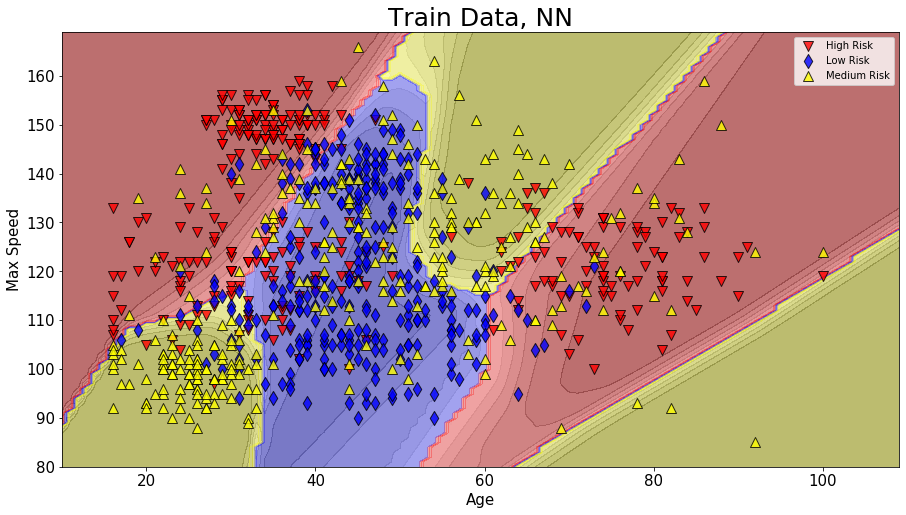

In [26]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN");

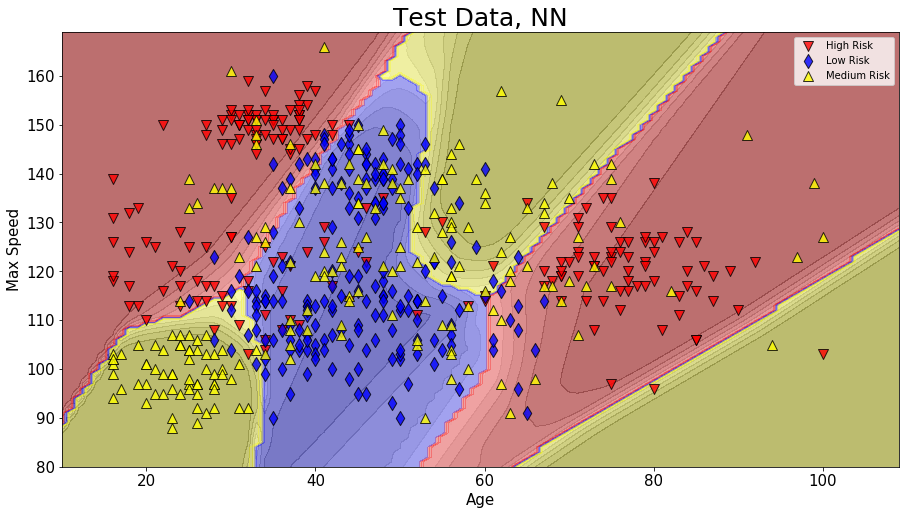

In [27]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN");

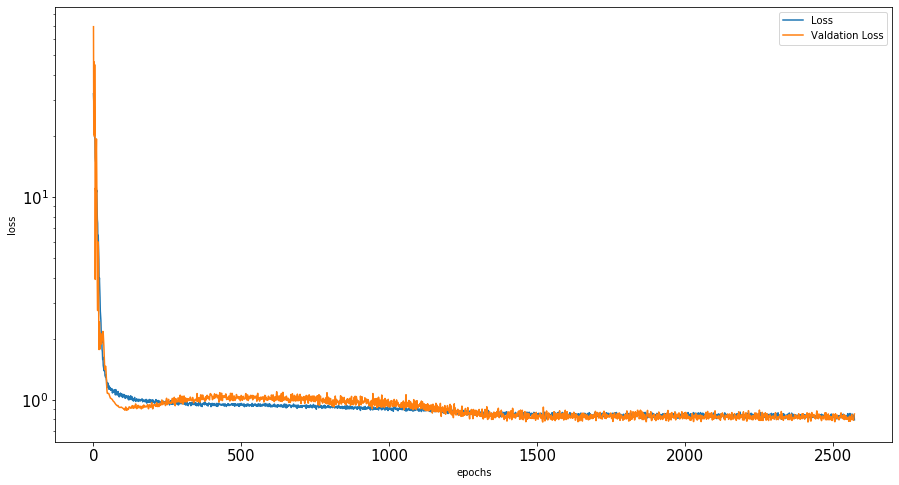

In [28]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"]);

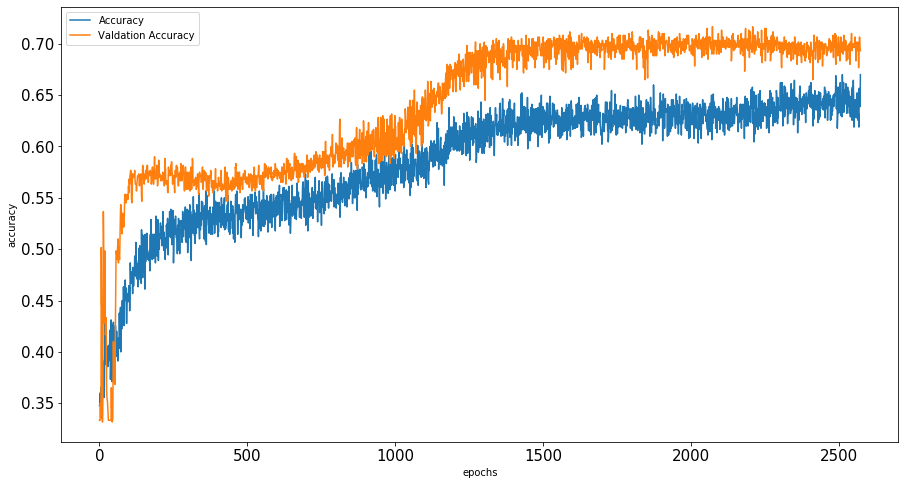

In [29]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"]);

# Step 2: Generate a larger and evenly distributed set of training data by feeding a grid of data through the neural network


In [30]:
xx,yy = meshGrid()
xx.shape, yy.shape

((90, 100), (90, 100))

In [31]:
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(9000, 2)

In [32]:
mesh_data[0]

array([80, 10])

In [33]:
pred = model.predict(mesh_data)
pred.shape

(9000, 3)

In [34]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(9000,)

In [35]:
np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([4457, 1532, 3011]))

# Step 3: Use this new training data to train a vanilla, unregularized decision tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.15 ms, sys: 0 ns, total: 7.15 ms
Wall time: 7.39 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

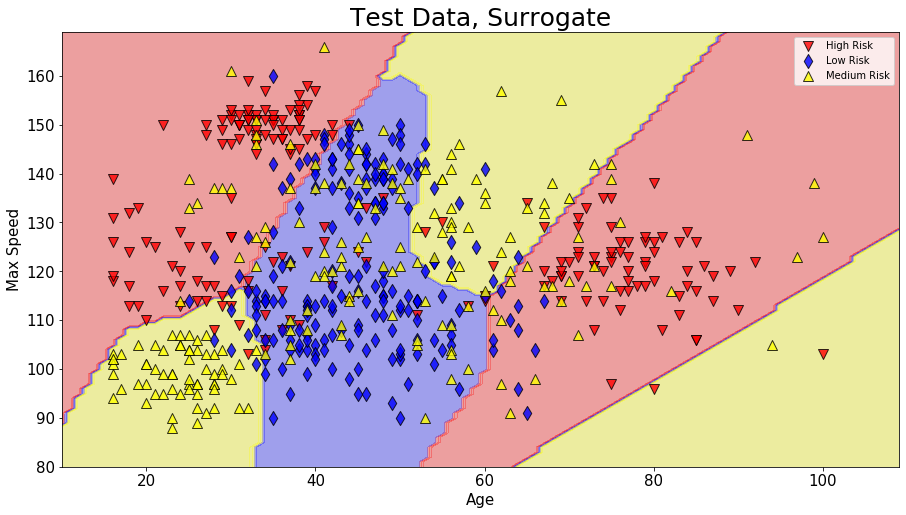

In [37]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [38]:
surrogate_model.tree_.max_depth

12

## Scores on newly generated data

In [39]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

## Scores on original data

In [40]:
surrogate_model.score(X_train_2_dim, y_train)

0.6933333333333334

In [41]:
surrogate_model.score(X_test_2_dim, y_test)

0.6933333333333334

# Step 4: Use typical regularization for decision tree not to make it generalize better, but to have a dial between explainability and accuracy


In [42]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=random_seed,
    min_samples_leaf = 500,
    max_leaf_nodes = 4
)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 5.99 ms, sys: 0 ns, total: 5.99 ms
Wall time: 8.32 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [43]:
surrogate_model.tree_.max_depth

3

In [44]:
surrogate_model.score(mesh_data, pred_sparse)

0.661

In [45]:
surrogate_model.score(X_train_2_dim, y_train)

0.5966666666666667

In [46]:
surrogate_model.score(X_test_2_dim, y_test)

0.6083333333333333

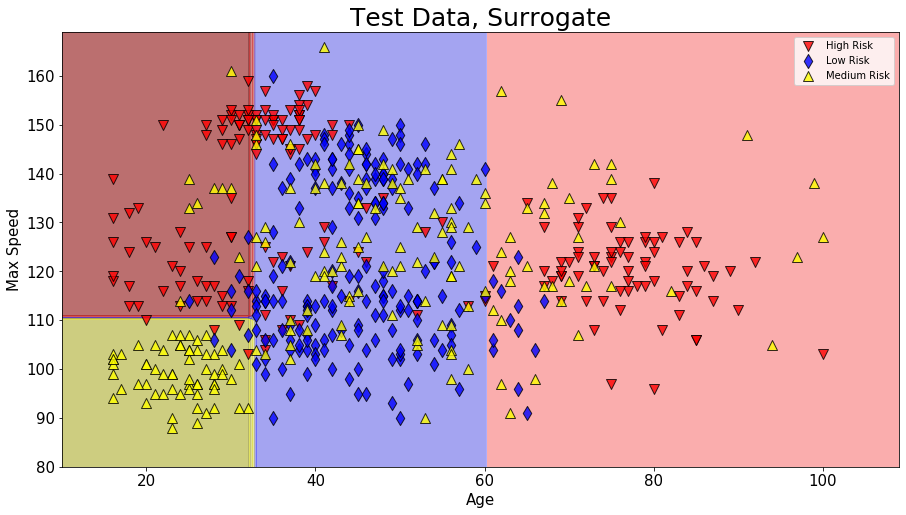

In [47]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

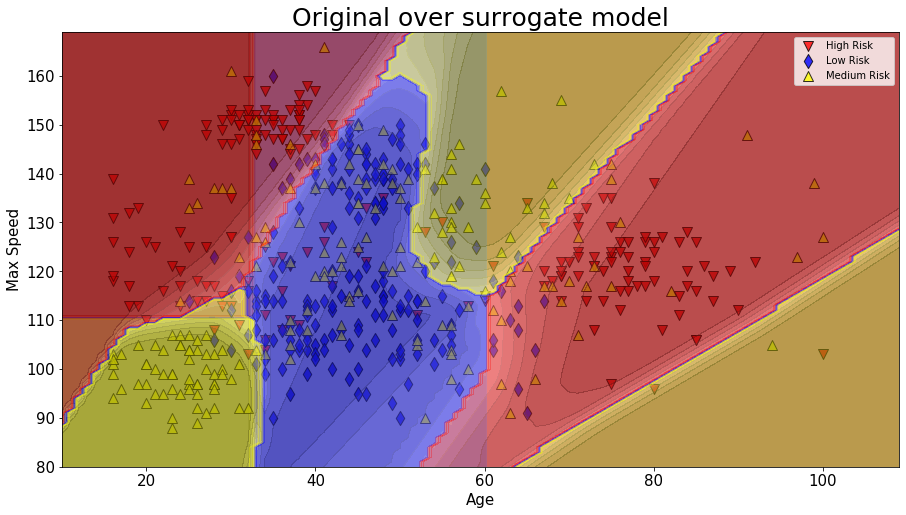

In [48]:
ax = plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test)
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, ax=ax, scatter=False,
                title="Original over surrogate model");

# Step 5: Use tree for explain plan and code generation

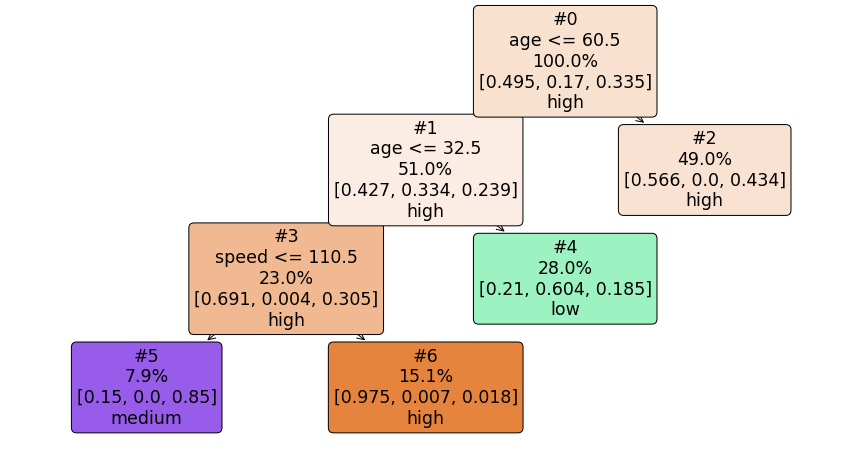

In [49]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['speed', 'age']
class_names=['high', 'low', 'medium']

# plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

In [50]:
# groups: "High Risk", "Low Risk", "Medium Risk"

sample = [110, 35]
# sample = [100, 60]
# sample = [120, 17]

surrogate_model.predict([sample])

array([1])

## Visualizing Prediction Path using dtreeviz

https://github.com/parrt/dtreeviz

In [51]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


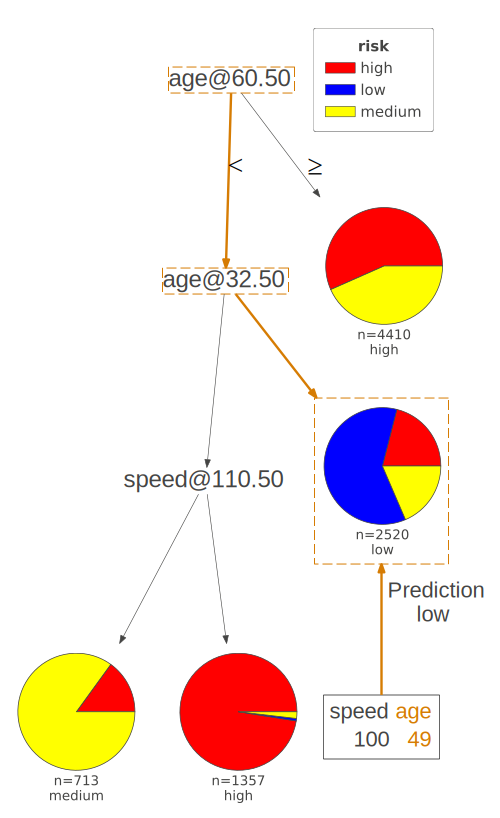

In [52]:
from dtreeviz.trees import dtreeviz

# sample = [100, 35]
# sample = [150, 30]
sample = [100, 49]
# sample = [100, 60]
# sample = [120, 17]

dtreeviz_colors = {'classes': [
                   None,  # 0 classes
                   None,  # 1 classes
                   None,  # 2 classes
                   colors
                   ]}

viz = dtreeviz(surrogate_model,
               mesh_data, pred_sparse,
               target_name='risk',
               feature_names=feature_names,
               class_names=class_names,
               X=sample,
               colors=dtreeviz_colors,
               fancy=False,
               scale=2,
#                scale=3
)
viz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


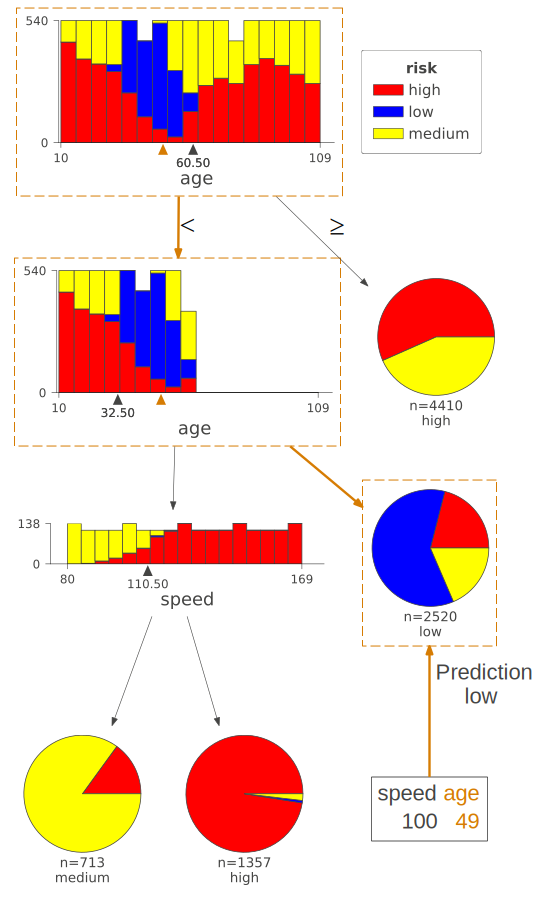

In [53]:
dtreeviz(surrogate_model,
         mesh_data, pred_sparse,
         target_name='risk',
         feature_names=feature_names,
         class_names=class_names,
         X=sample,
         colors=dtreeviz_colors,
         scale=2)

## Explaining decision


In [54]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

from sklearn.tree import _tree

def explain_decision(model, sample, feature_names, class_names):

  feature = model.tree_.feature
  threshold = model.tree_.threshold
  value = model.tree_.value

  node_indicator = model.decision_path([sample])
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]

  for node_id in node_index:
      if feature[node_id] == _tree.TREE_UNDEFINED:
          print(class_names[value[node_id].argmax(axis=1)[0]])
          continue

      if (sample[feature[node_id]] <= threshold[node_id]):
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print("%s(= %s) %s %s"
            % (feature_names[feature[node_id]],
              sample[feature[node_id]],
              threshold_sign,
              threshold[node_id]))
      
explain_decision(surrogate_model, sample, feature_names, class_names)      

age(= 49) <= 60.5
age(= 49) > 32.5
low


## Generating code

In [55]:
# derived from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

def generate_code(model, feature_names, class_names, flat=False, batch=True):
    tree_ = model.tree_
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth, conditions, outputs):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            condition = "{} <= {}".format(name, threshold)
            if not flat:
              print ("{}if {}:".format(indent, condition))
            recurse(tree_.children_left[node], depth + 1, conditions + [condition], outputs)
            condition = "{} > {}".format(name, threshold)
            if not flat:
              print ("{}else:  # if {}".format(indent, condition))
            recurse(tree_.children_right[node], depth + 1, conditions + [condition], outputs)
        else:
            prediction = class_names[value[node].argmax(axis=1)[0]]
            conjunction = ' and '.join(conditions)
            if flat and not batch:
              print ("  if {}:".format(conjunction))
            if not flat or not batch:
              print ("{}return '{}'".format(indent, prediction))
            else:
                if prediction in outputs: 
                  outputs[prediction] += [conjunction] 
                else:
                  outputs[prediction] = [conjunction]
        return outputs
              

    outputs = recurse(0, 1, [], {})
    if flat and batch:
      for prediction in outputs.keys():
          conjunctions = outputs[prediction]
          disjunction = ' or\n     '.join(conjunctions)
          print ("  if {}:".format(disjunction))
          print ("    return '{}':".format(prediction))
    
generate_code(surrogate_model, feature_names, class_names)    

def tree(speed, age):
  if age <= 60.5:
    if age <= 32.5:
      if speed <= 110.5:
        return 'medium'
      else:  # if speed > 110.5
        return 'high'
    else:  # if age > 32.5
      return 'low'
  else:  # if age > 60.5
    return 'high'


In [56]:
generate_code(surrogate_model, feature_names, class_names, flat=False)

def tree(speed, age):
  if age <= 60.5:
    if age <= 32.5:
      if speed <= 110.5:
        return 'medium'
      else:  # if speed > 110.5
        return 'high'
    else:  # if age > 32.5
      return 'low'
  else:  # if age > 60.5
    return 'high'


In [57]:
generate_code(surrogate_model, feature_names, class_names, flat=True, batch=False)

def tree(speed, age):
  if age <= 60.5 and age <= 32.5 and speed <= 110.5:
        return 'medium'
  if age <= 60.5 and age <= 32.5 and speed > 110.5:
        return 'high'
  if age <= 60.5 and age > 32.5:
      return 'low'
  if age > 60.5:
    return 'high'


In [58]:
generate_code(surrogate_model, feature_names, class_names, flat=True)

def tree(speed, age):
  if age <= 60.5 and age <= 32.5 and speed <= 110.5:
    return 'medium':
  if age <= 60.5 and age <= 32.5 and speed > 110.5 or
     age > 60.5:
    return 'high':
  if age <= 60.5 and age > 32.5:
    return 'low':


In [59]:
# derived from https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

def generate_code(model, feature_names, class_names):
    tree_ = model.tree_
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def remove_less_specific_conditions(conditions):
#         print(conditions)
        filered_conditions = []
        for name, op, threshold in conditions:
            if not any([filtered_name 
                    for filtered_name, filtered_op, filtered_threshold 
                    in conditions 
                    if name == filtered_name and 
                        op == filtered_op and 
                        ((op == '<=' and threshold > filtered_threshold) or 
                         (op == '>' and threshold < filtered_threshold))
                       ]):
                filered_conditions.append((name, op, threshold))
        return filered_conditions
    
    def conjunction_on_conditions(conditions):
        conjunction = ' and '.join(["{} {} {}".format(name, op, threshold) for name, op, threshold in conditions])
        return conjunction
    
    def recurse(node, depth, conditions, outputs):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            condition = (name, '<=', threshold)
            recurse(tree_.children_left[node], depth + 1, conditions + [condition], outputs)
            condition = (name, '>', threshold)
            recurse(tree_.children_right[node], depth + 1, conditions + [condition], outputs)
        else:
            prediction = class_names[value[node].argmax(axis=1)[0]]
            conjunction = conjunction_on_conditions(remove_less_specific_conditions(conditions))
            if prediction in outputs: 
              outputs[prediction] += [conjunction] 
            else:
              outputs[prediction] = [conjunction]
        return outputs
              

    outputs = recurse(0, 1, [], {})
    for prediction in outputs.keys():
          conjunctions = outputs[prediction]
          disjunction = ' or\n     '.join(conjunctions)
          print ("  if {}:".format(disjunction))
          print ("    return '{}':".format(prediction))
    
generate_code(surrogate_model, feature_names, class_names)    

def tree(speed, age):
  if age <= 32.5 and speed <= 110.5:
    return 'medium':
  if age <= 32.5 and speed > 110.5 or
     age > 60.5:
    return 'high':
  if age <= 60.5 and age > 32.5:
    return 'low':


# Step 6: Feature Importance and Bias

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/bias_castro.jpg?raw=1'>

In [0]:
surrogate_model.feature_importances_

array([0.25970202, 0.74029798])

In [0]:
# https://scikit-learn.org/stable/modules/permutation_importance.html
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance
from sklearn.inspection import permutation_importance

permutation_importance(surrogate_model, mesh_data, pred_sparse)

{'importances': array([[0.08877778, 0.08444444, 0.08      , 0.08544444, 0.08677778],
        [0.23844444, 0.23111111, 0.23077778, 0.24188889, 0.23511111]]),
 'importances_mean': array([0.08508889, 0.23546667]),
 'importances_std': array([0.00292912, 0.00427072])}

In [0]:
permutation_importance(surrogate_model, X_2_dim, y)

{'importances': array([[0.092     , 0.09133333, 0.082     , 0.09466667, 0.09933333],
        [0.22466667, 0.22333333, 0.26933333, 0.23333333, 0.246     ]]),
 'importances_mean': array([0.09186667, 0.23933333]),
 'importances_std': array([0.00567881, 0.01703852])}

# Summary

Our approach: _teach a decision tree using a stronger model (like a neural network) to fight overfitting, but still having all the benefits of a decision tree (like feature importance, uncertainty quantification, and explainability_

* Decision trees are great for explainability
  * Can quantity uncertainty 
  * gives you feature importance
  * can be made shallow and thus interpretable
  * can be used for debugging, finding unwanted bias, and genereally give explainability
* They, however, overfit no matter what you do
* Using a neural network as a teacher lets them overfit on very general data
  * This can be seen as a form of data augmentation
* This combines the best of both worlds  